# Final Project - Indoor Localization with BLE Beacons and RSSI

## Convolutional Neural Network Approach

# Setting Workspace

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.utils import np_utils
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Euclidian Distance between Two Points (Evaluation Metric)
It will be used to compare the actual position with the predicted position

In [ ]:
def l2_dist(p1, p2):
    x1,y1 = p1
    x2,y2 = p2
    x1, y1 = np.array(x1), np.array(y1)
    x2, y2 = np.array(x2), np.array(y2)
    dx = x1 - x2
    dy = y1 - y2
    dx = dx ** 2
    dy = dy ** 2
    dists = dx + dy
    dists = np.sqrt(dists)
    print('MAE: %.3f' % (np.mean(dists)))
    #print('MSE: %.3f' % (np.mean(np.square(dists))))
    return dists

# Getting Data Ready

In [ ]:
file = 'drive/My Drive/CBPF/Deep Learning/Projeto/iBeacon_RSSI_Labeled.csv'
data = pd.read_csv(file)

def fix_pos(x_cord):
    x = 87 - ord(x_cord.upper())
    return x

data['x'] = data['location'].str[0]
data['y'] = data['location'].str[1:]
data.drop(["location"], axis = 1, inplace = True)
data["x"] = data["x"].apply(fix_pos)
data["y"] = data["y"].astype(int)

data.head()

,date,b3001,b3002,b3003,b3004,b3005,b3006,b3007,b3008,b3009,b3010,b3011,b3012,b3013,x,y
0,10-18-2016 11:15:21,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200,8,2
1,10-18-2016 11:15:19,-200,-200,-200,-200,-200,-78,-200,-200,-200,-200,-200,-200,-200,7,1
2,10-18-2016 11:15:17,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200,7,1
3,10-18-2016 11:15:15,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200,7,1
4,10-18-2016 11:15:13,-200,-200,-200,-200,-200,-77,-200,-200,-200,-200,-200,-200,-200,7,1


Separating the data in Inputs and Labels

In [ ]:
# Input
X = data.iloc[:, 1:-2]
# Labels
y = data.iloc[:, -2:]
y = y.astype('float32')

Tranforming each input in a image

In [ ]:
X_img = np.zeros(shape = (X.shape[0], 25, 25, 1, ))
beacon_coords = {"b3001": (5, 9), 
                 "b3002": (9, 14), 
                 "b3003": (13, 14), 
                 "b3004": (18, 14), 
                 "b3005": (9, 11), 
                 "b3006": (13, 11), 
                 "b3007": (18, 11), 
                 "b3008": (9, 8), 
                 "b3009": (2, 3), 
                 "b3010": (9, 3), 
                 "b3011": (13, 3), 
                 "b3012": (18, 3), 
                 "b3013": (22, 3),}

for key, value in beacon_coords.items():
  X_img[:, value[0], value[1], 0] -= X[key].values/200
  print(key, value)



b3001 (5, 9)
b3002 (9, 14)
b3003 (13, 14)
b3004 (18, 14)
b3005 (9, 11)
b3006 (13, 11)
b3007 (18, 11)
b3008 (9, 8)
b3009 (2, 3)
b3010 (9, 3)
b3011 (13, 3)
b3012 (18, 3)
b3013 (22, 3)


A example of how a image looks

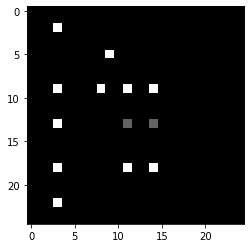

In [ ]:
from PIL import Image

img = Image.fromarray(X_img[500, :, :, 0] * 255)
plt.imshow(img)

Splitting the data

In [ ]:
seed = 7
np.random.seed(seed)

# Training and Test
X_train, X_test, y_train, y_test = train_test_split(X_img, y, test_size = 0.4, shuffle = False)
# Trainig and Validation
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = True)

# Building Model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Conv2DTranspose

In [ ]:
def create_deep():
  seed = 7
  np.random.seed(seed)
  inputs = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

  # A layer instance is callable on a tensor, and return a tensor 
  x = Conv2D(3, kernel_size=(3,3), activation='relu', padding = "valid",
            data_format="channels_last", )(inputs)
  x = MaxPooling2D(2)(x)
  x = Conv2D(6, kernel_size=(3,3), activation='relu', padding = "valid", 
            data_format="channels_last")(x)
  x = MaxPooling2D(2)(x)
  x = Conv2D(12, kernel_size=(3,3), activation='relu', padding = "valid", 
            data_format="channels_last")(x)
  x = Dense(50, activation='relu')(Flatten()(x))
  x = Dropout(0.3)(x)
  #predictions = Dense(2, activation='relu')(Flatten()(x))
  predictions = Dense(2, activation='relu')(x)

  # This creates a model that includes
  # the Input layer and three Dense layers
  model = Model(inputs=inputs, outputs=predictions)
  model.compile(optimizer=Adam(0.001),
                loss='mse')
  return model

model = create_deep()
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0, 
                               mode='auto', restore_best_weights=True)

out = model.fit(x = X_train_2, y = y_train_2, 
                 validation_data = (X_val, y_val),
                 epochs=1000, 
                 batch_size=64, 
                 #batch_size=200, 
                 verbose=0, 
                 callbacks = [early_stopping])

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 25, 25, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 23, 23, 3)         30        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 11, 11, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 9, 9, 6)           168       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 6)           0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 2, 2, 12)          660       
_________________________________________________________________
flatten_8 (Flatten)          (None, 48)              

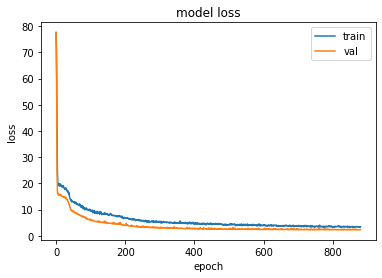

In [ ]:
# summarize history for loss
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
mse = model.evaluate(X_val, y_val, verbose=0)
print(mse)

2.2141671180725098


# K-fold Cross-Validation

>2.876
>2.735
>2.147
>2.322
>2.052
MSE: 2.426 (0.325)


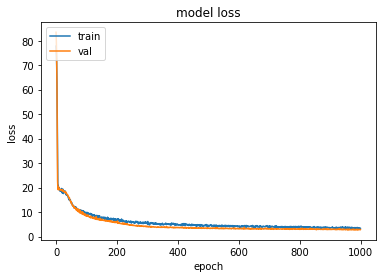

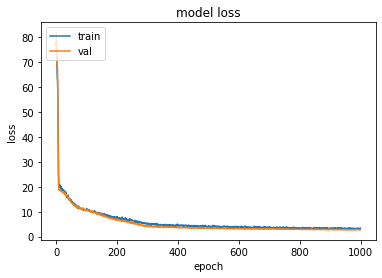

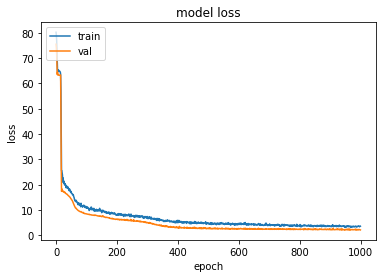

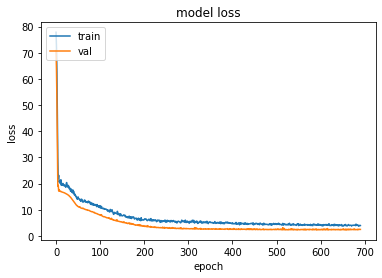

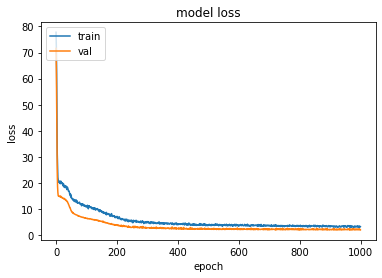

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
  results = list()
  hist = list()
  #n_inputs, n_outputs = X.shape[1], y.shape[1]
  # define evaluation procedure
  cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
  # enumerate folds
  for train_ix, val_ix in cv.split(X):
    # prepare data
    X_train, X_val = X[train_ix], X[val_ix]
    y_train, y_val = y[train_ix], y[val_ix]
    # define model
    #model = get_model(n_inputs, n_outputs)
    model = create_deep()
    # fit model
    #model.fit(X_train, y_train, verbose=0, epochs=100)
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='auto', restore_best_weights=True)
    out = model.fit(x = X_train, y = y_train, 
                 validation_data = (X_val, y_val),
                 epochs=1000, 
                 batch_size=64, 
                 verbose=0, 
                 callbacks = [early_stopping])
    # evaluate model on test set
    mse = model.evaluate(X_val, y_val, verbose=0)
    # store result
    print('>%.3f' % mse)
    results.append(mse)
    hist.append(out)
  return results, hist
 
# load dataset
#X, y = get_dataset()
# evaluate model
X_train_np = np.array(X_train_2)
y_train_np = np.array(y_train_2)
results, hist = evaluate_model(X_train_np, y_train_np)
# summarize performance
print('MSE: %.3f (%.3f)' % (np.mean(results), np.std(results)))

#mse = model.evaluate(X_test, y_test)
#print('Test result: >%.3f' % mse)

for i in range(0, 5):
  plt.plot(hist[i].history['loss'])
  plt.plot(hist[i].history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

## Training with full dataset

18/18 [==============================] - 0s 2ms/step - loss: 2.1620
Test result: >2.162


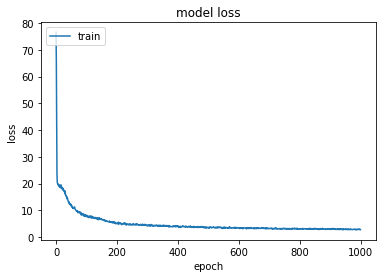

In [ ]:
seed = 7
np.random.seed(seed)

#X_frames = [X_train_2, X_val]
y_frames = [y_train_2, y_val]

X_train_shuffled = np.concatenate((X_train_2, X_val), axis=0)
y_train_shuffled = pd.concat(y_frames)


model = create_deep()
early_stopping = EarlyStopping(monitor='loss', patience=100, verbose=0, mode='auto', restore_best_weights=True)
out = model.fit(x = X_train_shuffled, y = y_train_shuffled,
              epochs=1000, 
              batch_size=64, 
              verbose=0,
              callbacks = [early_stopping])

mse = model.evaluate(X_test, y_test)
print('Test result: >%.3f' % mse)

plt.plot(out.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Calculating euclidian error

In [ ]:
preds = model.predict(X_test)
l2dists = l2_dist((preds[:, 0], preds[:, 1]), (y_test["x"], y_test["y"]))

MAE: 1.817


In [ ]:
df = y_test 
df['error'] = l2dists
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,x,y,error
852,14.0,8.0,1.233608
853,14.0,8.0,2.308534
854,14.0,8.0,0.203521
855,14.0,8.0,0.187745
856,14.0,8.0,2.386383


Heatmap of average euclidian error

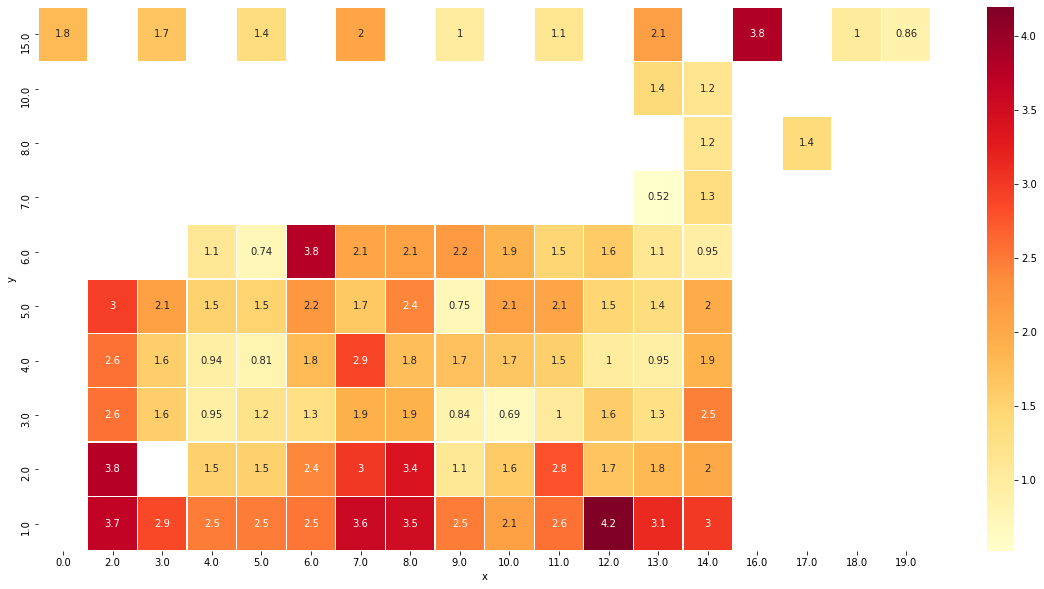

In [ ]:
import seaborn as sns

heatmap_data = pd.pivot_table(df, values='error', 
                              index='y', 
                              columns='x', 
                              aggfunc='mean',)
                              #fill_value=0)
#heatmap_data.head()

#sns.clustermap(heatmap_data, cmap="mako", row_cluster=False, col_cluster=False , cbar_pos=(0, .2, .03, .4))
#plt.savefig('heatmap_with_Seaborn_clustermap_python.jpg',
#            dpi=150, figsize=(8,12))

fig, ax = plt.subplots(figsize=(20,10))

heatmap_data.sort_index(level=0, ascending=False, inplace=True)
sns.heatmap(heatmap_data, annot=True, linewidths=0.4, cmap="YlOrRd", ax=ax)
#sns.heatmap(heatmap_data, linewidths=0.4, cmap="YlOrRd")

Adjust the metric to meters

In [ ]:
preds_real = preds * 3.0
y_test_real = y_test * 3.0
l2dists_real = l2_dist((preds_real[:, 0], preds_real[:, 1]), (y_test_real["x"], y_test_real["y"]))

MAE: 5.451


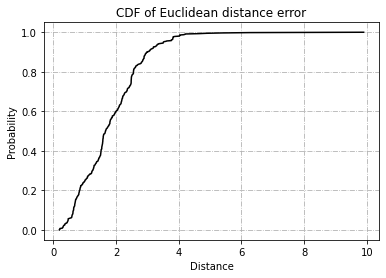

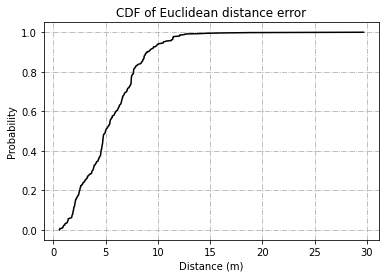

In [ ]:
sortedl2 = np.sort(l2dists)
prob = 1.0 * np.arange(len(sortedl2)) / (len(sortedl2) - 1) 
fig, ax = plt.subplots()
lg1 = ax.plot(sortedl2, prob, color='black')

plt.title('CDF of Euclidean distance error')
plt.xlabel('Distance')
plt.ylabel('Probability')
plt.grid(True)
gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle('-.')

#######################

sortedl2 = np.sort(l2dists_real)
prob = 1.0 * np.arange(len(sortedl2)) / (len(sortedl2) - 1) 
fig, ax = plt.subplots()
lg1 = ax.plot(sortedl2, prob, color='black')

plt.title('CDF of Euclidean distance error')
plt.xlabel('Distance (m)')
plt.ylabel('Probability')
plt.grid(True)
gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle('-.')

#plt.savefig('Figure_CDF_error.png', dpi=300)
plt.show()
plt.close()